# DNN 모델

- 미리 정리된 학습데이터를 사용
- dnn 적용
- cross validation 으로 최적 hyper parameter 찾기
    - epoch, layers, units 등
- ensemble 적용
    - 최종 hyper parameter 기반으로 ensemble 구성

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import KFold
import time
import matplotlib.pyplot as plt

/home/shkim/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## model class

In [2]:
class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name

    def build_net(self, features=8, layers=4, units=100):
        with tf.variable_scope(self.name) as scope:
            # dropout (keep_prob) rate  0.7~0.5 on training, but should be 1
            # for testing
            self.training = tf.placeholder(tf.bool)

            # input place holders
            self.X = tf.placeholder(tf.float32, [None, features])
            self.Y = tf.placeholder(tf.float32, [None, 1])
            self.learning_rate = tf.placeholder(tf.float32)
            
            #initializer = tf.contrib.layers.xavier_initializer()
            
            hiddenLayer = self.X
            for i in range(layers):
                #hiddenLayer = tf.layers.dense(inputs=hiddenLayer, units=units, activation=tf.nn.relu, kernel_initializer=initializer)
                #hiddenLayer = tf.layers.dropout(inputs=hiddenLayer, rate=0.5, training=self.training)
                hiddenLayer = self.dense_relu_dropout (hiddenLayer, units, 'layer'+str(i))
                #hiddenLayer = self.dense_batch_relu (hiddenLayer, units, 'layer'+str(i))
                
            self.logits = tf.layers.dense(inputs=hiddenLayer, units=1)
        
        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits, labels=self.Y))
        #update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        #with tf.control_dependencies(update_ops):
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)

        self.prediction = tf.round(tf.nn.sigmoid(self.logits))
        correct_prediction = tf.equal(self.prediction, self.Y)
        self.correct_count = tf.reduce_sum(tf.cast(correct_prediction, tf.float32))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def dense (self, x, size, scope):
        return tf.contrib.layers.fully_connected(x, size, activation_fn=None, scope=scope)
    
    def dense_batch_relu(self, x, size, scope, phase=True):
        with tf.variable_scope(scope):
            h1 = tf.contrib.layers.fully_connected(x, size, activation_fn=None, scope='dense')
            h2 = tf.contrib.layers.batch_norm(h1, center=True, scale=True, is_training=phase, scope='bn')
            return tf.nn.relu(h2, 'relu')
        
    def dense_relu_dropout(self, x, size, scope, training=True):
        with tf.variable_scope(scope):
            initializer = tf.contrib.layers.xavier_initializer()
            hiddenLayer = tf.layers.dense(inputs=x, units=units, activation=tf.nn.relu, kernel_initializer=initializer)
            hiddenLayer = tf.layers.dropout(inputs=hiddenLayer, rate=0.5, training=self.training)
            return hiddenLayer
    
    def predict(self, x_test, training=False):
        return self.sess.run(self.prediction, feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.training: training})
    
    def train(self, x_data, y_data, learning_rate, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.X: x_data, self.Y: y_data, self.learning_rate: learning_rate, self.training: training})

## cross validation 함수

In [3]:
def cross_valid (sess, train_x, train_y, foldCount, layers, units, epochs, learning_rate):
    
    fig = plt.figure(figsize=(18, 6))
    
    k_fold = KFold(foldCount)

    models_v = []
    for m in range(foldCount):
        models_v.append(Model(sess, "model_v" + str(m)))
        models_v[m].build_net(features=train_x.shape[1], layers=layers, units=units)

    sess.run(tf.global_variables_initializer())

    start_time = time.time()

    valid_acc = []
    idx = 0;
    for train_indices, valid_indices in k_fold.split(train_x):
        #print('Train: %s \n| test: %s\n' % (train_indices, test_indices))
        train_acc_collect = []
        valid_acc_collect = []

        m = models_v[idx]

        start_time_k = time.time()

        X_train = train_x.iloc[train_indices].values
        Y_train = train_y.iloc[train_indices].values.reshape([-1,1])
        X_valid = train_x.iloc[valid_indices].values
        Y_valid = train_y.iloc[valid_indices].values.reshape([-1,1])

        fig.add_subplot(foldCount / 5, 5, idx+1)
        
        for i in range(epochs):
            c, _ = m.train(X_train, Y_train, learning_rate)
            accuracy_t = m.get_accuracy(X_train, Y_train)
            accuracy_v = m.get_accuracy(X_valid, Y_valid)
            train_acc_collect.append(accuracy_t)
            valid_acc_collect.append(accuracy_v)

        accuracy = m.get_accuracy(X_valid, Y_valid)
        print("[", idx, "] accuracy=%.2f" % accuracy, " %.2f seconds" % (time.time() - start_time_k))
        valid_acc.append(accuracy)

        plt.plot(train_acc_collect, "r")
        plt.plot(valid_acc_collect, "g")
        plt.ylim(0, 1)

        idx = idx + 1
    
    plt.show()
    print(" %.2f seconds" % (time.time() - start_time))
    return valid_acc, round(np.mean(valid_acc) * 100, 2)

## 학습데이터 읽어 오기
학습데이터는 아래의 코드로 전처리된 것을 사용한다.

[김성헌_01_데이터분석](./김성헌_01_데이터분석.ipynb)


In [4]:
train = pd.read_csv('train_01.csv')
train.head()

,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,0,3,0,1.0,0.0,2.0,0,0,0.4
1,1,1,1,3.0,2.0,0.8,1,2,0.4
2,1,3,1,1.0,0.0,2.0,0,1,0.0
3,1,1,1,2.0,2.0,0.8,0,2,0.4
4,0,3,0,2.0,0.0,2.0,0,0,0.0


In [5]:
train_y = train['Survived']
train_x = train.drop('Survived', axis=1)

In [6]:
train_y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [7]:
type(train_y)

pandas.core.series.Series

In [8]:
train_x.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,0,1.0,0.0,2.0,0,0,0.4
1,1,1,3.0,2.0,0.8,1,2,0.4
2,3,1,1.0,0.0,2.0,0,1,0.0
3,1,1,2.0,2.0,0.8,0,2,0.4
4,3,0,2.0,0.0,2.0,0,0,0.0


## cross validation 으로 hyper parameter 결정

Instructions for updating:
Use the retry module or similar alternatives.
[ 0 ] accuracy=0.81  2.07 seconds
[ 1 ] accuracy=0.87  2.01 seconds
[ 2 ] accuracy=0.78  2.24 seconds
[ 3 ] accuracy=0.89  2.34 seconds
[ 4 ] accuracy=0.83  2.04 seconds
[ 5 ] accuracy=0.83  2.58 seconds
[ 6 ] accuracy=0.80  2.43 seconds
[ 7 ] accuracy=0.79  2.18 seconds
[ 8 ] accuracy=0.89  2.25 seconds
[ 9 ] accuracy=0.85  2.04 seconds


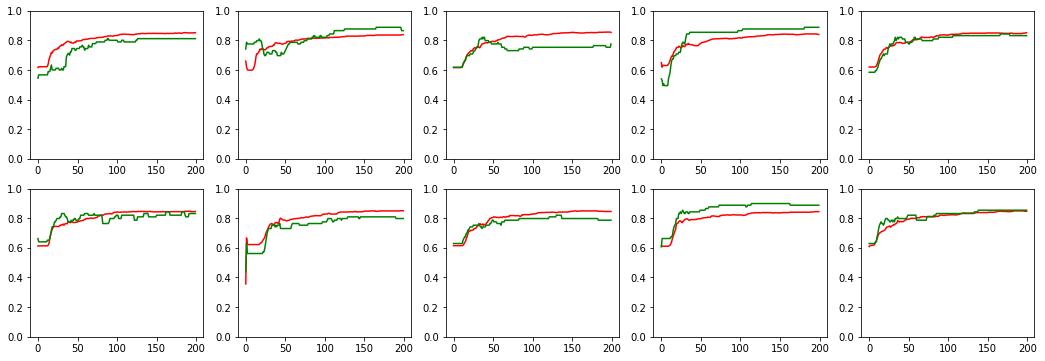

 22.62 seconds
avg_acc:  83.28


In [9]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

with tf.variable_scope("case1"):
    # hyper parameters
    learning_rate = 0.001
    training_epochs = 200
    layers = 4
    units = 100
    valid_acc, avg_acc = cross_valid (sess, train_x, train_y, 10, layers, units, training_epochs, learning_rate)
    print("avg_acc: ", avg_acc)

[ 0 ] accuracy=0.81  1.22 seconds
[ 1 ] accuracy=0.88  1.32 seconds
[ 2 ] accuracy=0.76  1.26 seconds
[ 3 ] accuracy=0.88  1.16 seconds
[ 4 ] accuracy=0.83  1.10 seconds
[ 5 ] accuracy=0.80  1.09 seconds
[ 6 ] accuracy=0.80  1.24 seconds
[ 7 ] accuracy=0.79  1.28 seconds
[ 8 ] accuracy=0.90  1.09 seconds
[ 9 ] accuracy=0.85  1.09 seconds


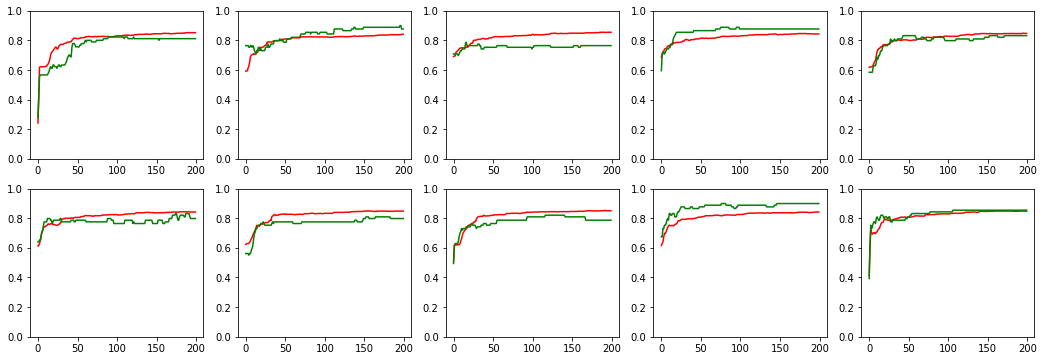

 12.29 seconds
avg_acc:  82.94


In [10]:
with tf.variable_scope("case2"):
    # hyper parameters
    learning_rate = 0.001
    training_epochs = 200
    layers = 2
    units = 100
    valid_acc, avg_acc = cross_valid (sess, train_x, train_y, 10, layers, units, training_epochs, learning_rate)
    print("avg_acc: ", avg_acc)

[ 0 ] accuracy=0.77  0.61 seconds
[ 1 ] accuracy=0.79  0.49 seconds
[ 2 ] accuracy=0.76  0.53 seconds
[ 3 ] accuracy=0.85  0.52 seconds
[ 4 ] accuracy=0.81  0.50 seconds
[ 5 ] accuracy=0.82  0.46 seconds
[ 6 ] accuracy=0.79  0.50 seconds
[ 7 ] accuracy=0.80  0.50 seconds
[ 8 ] accuracy=0.85  0.51 seconds
[ 9 ] accuracy=0.80  0.46 seconds


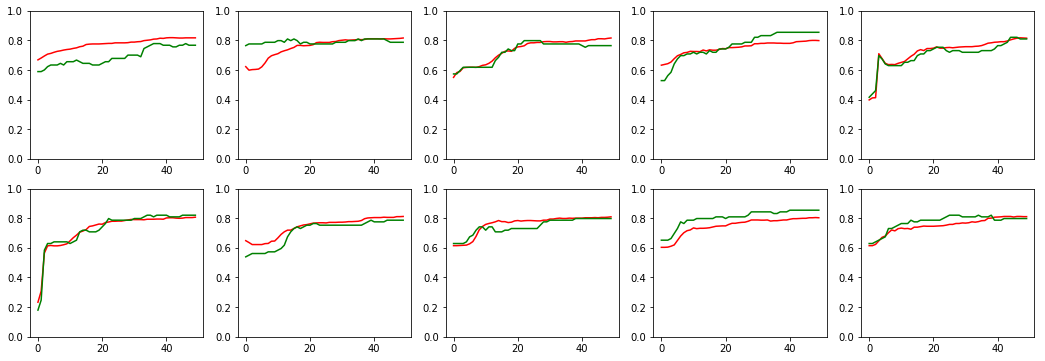

 5.49 seconds
avg_acc:  80.36


In [11]:
with tf.variable_scope("case4"):
    # hyper parameters
    learning_rate = 0.001
    training_epochs = 50
    layers = 2
    units = 100
    valid_acc, avg_acc = cross_valid (sess, train_x, train_y, 10, layers, units, training_epochs, learning_rate)
    print("avg_acc: ", avg_acc)

## Ensemble Model 학습
hyper paramers
- learning_rate: 0.001
- training_epoches: 200
- layers: 2
- units:100

- ensemble models: 10

Learning Started!
Learning Finished!
--- 9.40 seconds ---


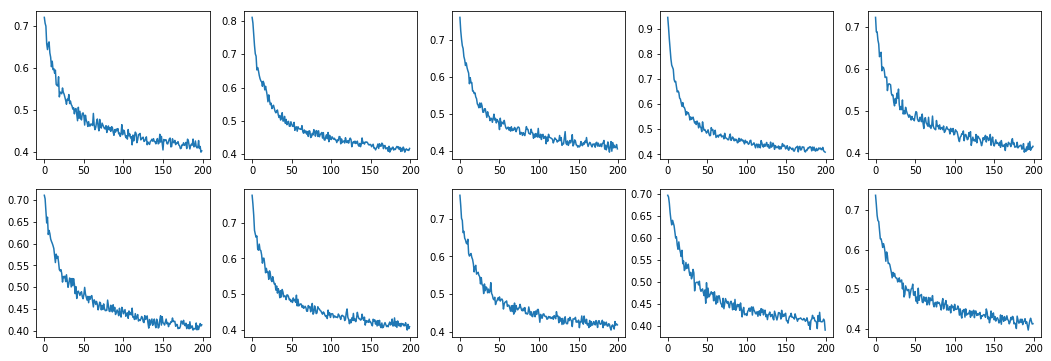

In [12]:
with tf.variable_scope("submission_model"):
    learning_rate = 0.001
    training_epochs = 200
    layers = 2
    units = 100

    ensembles = 10
    models = []
    for i in range(ensembles):
        model = Model(sess, "model" + str(i))
        model.build_net(features=train_x.shape[1], layers=layers, units=units)
        models.append(model)

    sess.run(tf.global_variables_initializer())
    
    print('Learning Started!')
    start_time = time.time()
    
    cost_collect = np.zeros([len(models), training_epochs])
    
    for i in range(training_epochs):
        for m_idx, m in enumerate(models):
            c, _ = m.train(train_x.values, train_y.values.reshape([-1,1]), learning_rate)
            cost_collect[m_idx, i] = c;
            
    print('Learning Finished!')
    print("--- %.2f seconds ---" %(time.time() - start_time))
    
    fig = plt.figure(figsize=(18, 6))
    for m_idx in range(len(models)):
        fig.add_subplot(len(models) / 5, 5, m_idx+1)
        plt.plot(cost_collect[m_idx])
    plt.show() 

## 학습 데이터로 성능평가

In [13]:
predictions = np.zeros([train_x.shape[0],1])

for m_idx, m in enumerate(models):
    accuracy = m.get_accuracy(train_x.values, train_y.values.reshape([-1,1]))
    p = m.predict(train_x.values)
    print(m_idx, "accuracy: %.2f" % accuracy)
    predictions += p

predictions = predictions / len(models)
predictions_round = tf.round(predictions)
ensemble_correct = tf.equal(predictions_round, train_y.values.reshape([-1,1]))
ensemble_accuracy = tf.reduce_mean(tf.cast(ensemble_correct, tf.float32))
print('Ensemble accuracy: %.2f' % sess.run(ensemble_accuracy))

0 accuracy: 0.85
1 accuracy: 0.84
2 accuracy: 0.85
3 accuracy: 0.84
4 accuracy: 0.84
5 accuracy: 0.85
6 accuracy: 0.85
7 accuracy: 0.84
8 accuracy: 0.85
9 accuracy: 0.85
Ensemble accuracy: 0.85


## 테스트 데이터로 prediction

In [14]:
test = pd.read_csv("test_01.csv")
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,892,3,0,2.0,0.0,2.0,2,0,0.0
1,893,3,1,3.0,0.0,2.0,0,2,0.4
2,894,2,0,3.0,0.0,2.0,2,0,0.0
3,895,3,0,2.0,0.0,2.0,0,0,0.0
4,896,3,1,1.0,0.0,2.0,0,2,0.8


In [15]:
test_x = test.drop("PassengerId", axis=1)
test_x.head()

,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,FamilySize
0,3,0,2.0,0.0,2.0,2,0,0.0
1,3,1,3.0,0.0,2.0,0,2,0.4
2,2,0,3.0,0.0,2.0,2,0,0.0
3,3,0,2.0,0.0,2.0,0,0,0.0
4,3,1,1.0,0.0,2.0,0,2,0.8


In [16]:
test_predictions = np.zeros([test_x.shape[0],1])

for m_idx, m in enumerate(models):
    result = m.predict(test_x.values)
    test_predictions += result

test_predictions = test_predictions / len(models)
predictions_round = tf.round(test_predictions)
result = sess.run(predictions_round)
result = result.reshape([-1]).astype(int)

submission = pd.DataFrame({"PassengerId": test["PassengerId"], "Survived":result})
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [17]:
submission.to_csv('submission.csv', index=False)